
# Análisis de Datos Mineros - Versión Mejorada

Este notebook realiza un análisis con clustering basado en coordenadas espaciales (IX, IY, IZ) y variables mineras (CU, AU, densidad). Se aplican varias mejoras en la visualización, incluyendo la exclusión de bloques con ley cero para las gráficas 3D.



## Cargar y visualizar los datos

Primero, cargamos los datos desde un archivo CSV y visualizamos las primeras filas para entender la estructura del dataset.


In [14]:

import pandas as pd

# Cargar el archivo
file_path = 'Marvin.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas para entender la estructura
data.head()


,IX,IY,IZ,CU,AU,density,economic value process,economic value waste
0,1,1,1,0.0,0.0,2.26667,-299880.0,-55080.0
1,1,1,2,0.0,0.0,2.26667,-299880.0,-55080.0
2,1,1,3,0.0,0.0,2.26667,-299880.0,-55080.0
3,1,1,4,0.0,0.0,2.26667,-299880.0,-55080.0
4,1,1,5,0.0,0.0,2.26667,-299880.0,-55080.0



## Preprocesamiento de los datos

Eliminamos las columnas que no utilizaremos para el análisis: `economic value process` y `economic value waste`.


In [15]:

# Eliminar columnas no deseadas
data_cleaned = data.drop(['economic value process', 'economic value waste'], axis=1)
print(data.shape)
data_cleaned.head()


(53271, 8)


,IX,IY,IZ,CU,AU,density
0,1,1,1,0.0,0.0,2.26667
1,1,1,2,0.0,0.0,2.26667
2,1,1,3,0.0,0.0,2.26667
3,1,1,4,0.0,0.0,2.26667
4,1,1,5,0.0,0.0,2.26667



## Visualización de las leyes de cobre, oro y densidad en base a las coordenadas XYZ (Excluyendo leyes cero)

Excluimos de las gráficas los bloques con ley cero, para centrarnos en los datos significativos.


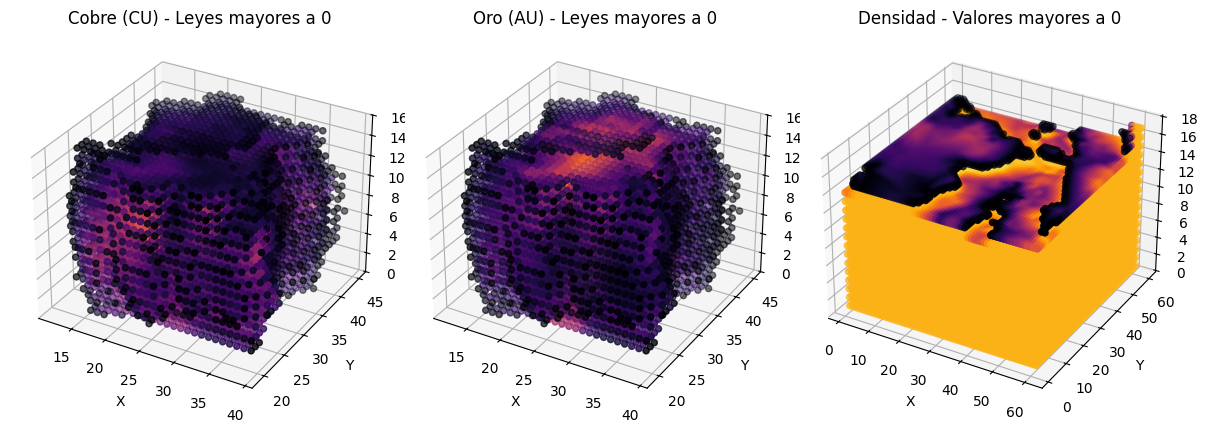

In [16]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Filtrar los datos donde las leyes no sean cero
filtered_data_cu = data_cleaned[data_cleaned['CU'] > 0]
filtered_data_au = data_cleaned[data_cleaned['AU'] > 0]
filtered_data_density = data_cleaned[data_cleaned['density'] > 0]

# Crear gráfica 3D para las leyes de cobre, oro y densidad
fig = plt.figure(figsize=(12, 8))

# Gráfica para el Cobre (CU)
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(filtered_data_cu['IX'], filtered_data_cu['IY'], filtered_data_cu['IZ'], c=filtered_data_cu['CU'], cmap='inferno')
ax1.set_title('Cobre (CU) - Leyes mayores a 0')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Gráfica para el Oro (AU)
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(filtered_data_au['IX'], filtered_data_au['IY'], filtered_data_au['IZ'], c=filtered_data_au['AU'], cmap='inferno')
ax2.set_title('Oro (AU) - Leyes mayores a 0')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Gráfica para la Densidad (density)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(filtered_data_density['IX'], filtered_data_density['IY'], filtered_data_density['IZ'], c=filtered_data_density['density'], cmap='inferno')
ax3.set_title('Densidad - Valores mayores a 0')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.show()



## Método del Codo para determinar la cantidad óptima de clusters

Utilizamos el método del codo para encontrar el número adecuado de clusters en base a las columnas `IX`, `IY`, `IZ`, `CU`, `AU`, y `density`. Normalizamos los datos antes de aplicar el KMeans.


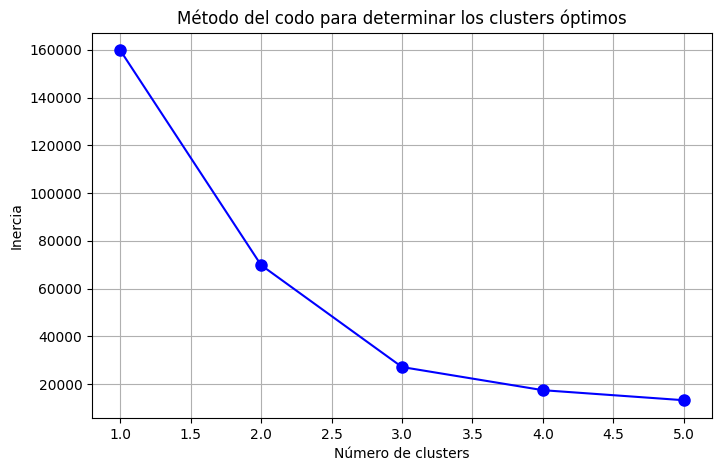

In [17]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalizar los datos para el clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned[['CU', 'AU', 'density']])

# Aplicar el método del codo
inertia = []
K = range(1, 6)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar los clusters óptimos')
plt.grid(True)
plt.show()



## Aplicar KMeans y calcular la puntuación de Silueta

Seleccionamos un número de clusters (en este caso, 3) y aplicamos el algoritmo KMeans. Luego calculamos la puntuación de silueta, que nos indica qué tan bien separados están los clusters.


In [18]:

from sklearn.metrics import silhouette_score

# Aplicar KMeans con 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Añadir los clusters al dataset
data_cleaned['Cluster'] = clusters

# Calcular la puntuación de la silueta
silhouette_avg = silhouette_score(data_scaled, clusters)

# Mostrar la puntuación de silueta promedio
silhouette_avg


np.float64(0.8965317795602474)


## Visualización de los clusters en el espacio XYZ

Finalmente, visualizamos los clusters obtenidos en el espacio tridimensional (XYZ) para observar cómo se agrupan los datos.


In [19]:
def plot_by_cluster(data, cluster_column, color_column):
    # Graficar los clusters en el espacio XYZ
    _df = data.copy()
    _df = _df[_df['Cluster']==cluster_column]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(_df['IX'], _df['IY'], _df['IZ'], c=_df[color_column], cmap='viridis')
    ax.set_title('Clusters en el espacio XYZ')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.colorbar(scatter)
    plt.show()


In [20]:
data_cleaned.groupby('Cluster').mean()

,IX,IY,IZ,CU,AU,density
Cluster,,,,,,
0,26.060851,31.336968,8.008794,0.348797,0.298401,2.629386
1,31.572980,30.610155,7.369536,0.001794,0.001470,2.260518
2,28.995858,28.581702,14.752259,0.009512,0.020800,0.578973
3,24.677184,32.442152,7.739078,0.688123,0.689757,2.673322


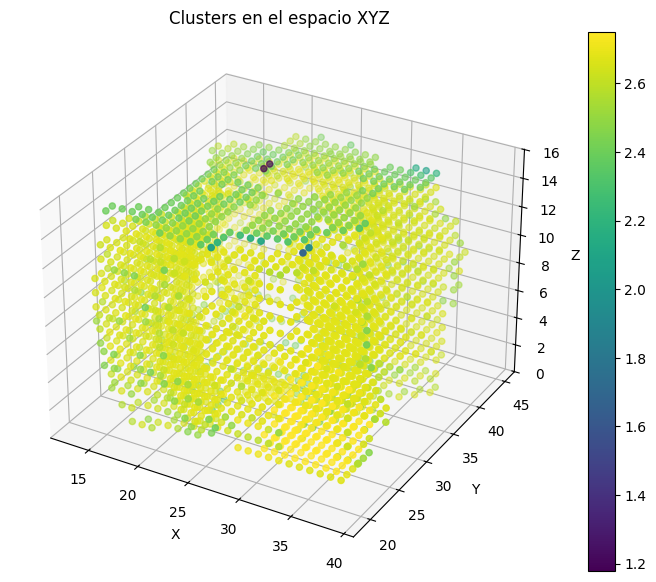

In [21]:
plot_by_cluster(data_cleaned, 0, 'density')

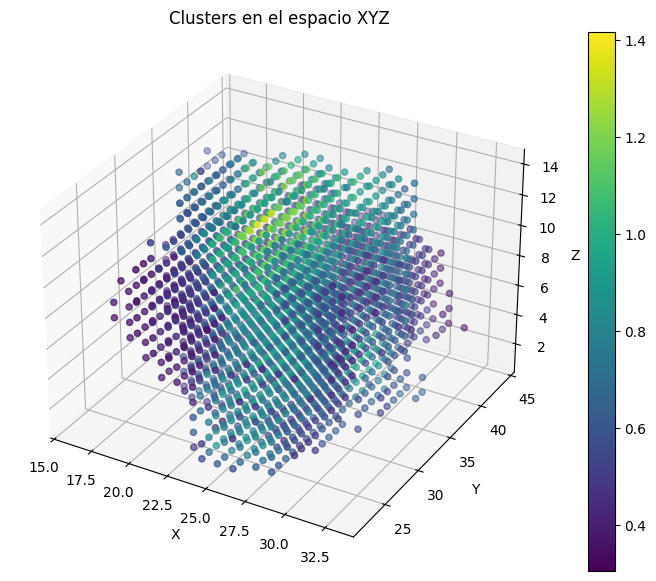

In [22]:
plot_by_cluster(data_cleaned, 3, 'AU')

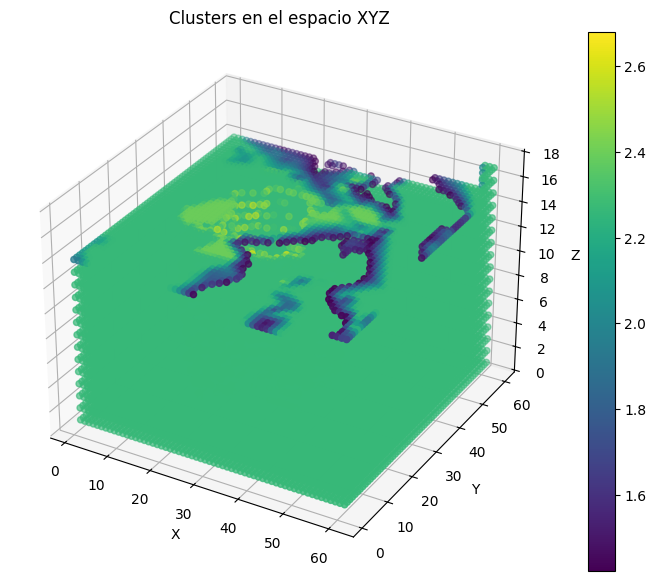

In [23]:
plot_by_cluster(data_cleaned, 1, 'density')

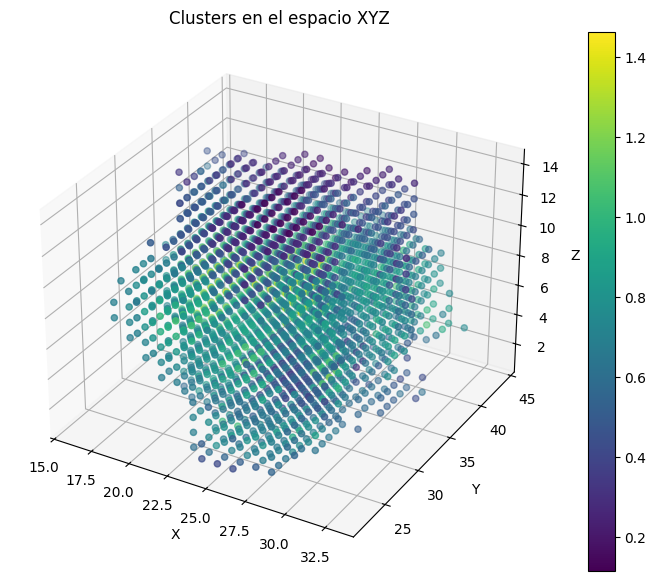

In [24]:
plot_by_cluster(data_cleaned, 3, 'CU')